# Modeling

## Imports

In [1]:
#File and name management libraries
import os
import shutil
import glob
from pathlib import Path

#Math & data handling libraries
import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#dates and timeframe libraries
import datetime
import matplotlib.dates as mdates
from datetime import datetime, timedelta

#Assocations and correlations libraries
import ppscore as pps

#Machine learning libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pycaret.regression import *

#Other file format libraries
#!pip install xlsxwriter
import xlsxwriter

In [2]:
from pycaret.utils import version
print('Pycaret Version: ', version())

Pycaret Version:  3.0.0.rc4


# Targe feature

In [3]:
#Set the target feature
TARGET_FEATURE = 'wti_price'

#Set date to plot
DATE_ZOOM = '2021-03-01'

In [5]:
#Set prediction timeline and models {month: file_name}
models = {
        "1":{
            'model_file': 'regression_model_1m'},
    
        "2":{
            'model_file': 'regression_model_2m'},
    
        "3":{
            'model_file': 'regression_model_3m'},

        "4":{
            'model_file': 'regression_model_4m'},
    
        "5":{
            'model_file': 'regression_model_5m'},
    
        "6":{
            'model_file': 'regression_model_6m'},
        }
        

## Load Models

In [6]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

In [7]:
#define folder
m_path = ROOT_DIR + '\\models\\'

#cast pipelines to a dict
for key,value in models.items():
    #get the file name
    model_name = models[key]['model_file']

    #read final model metrics and store in the dict
    excel_file = m_path + model_name + '\\pycaret_tables.xlsx'
    models[key]['metrics'] = pd.read_excel(open(excel_file, 'rb',),index_col = 0, sheet_name='pred_final')

    #load pipeline
    finalized_model = load_model(m_path + model_name)
    
    #cast the pipeline to the dict item with proper key 
    models[key]['pipeline'] = finalized_model

ValueError: Worksheet named 'pred_final' not found

## Load Data

### Read processed data

In [ ]:
#Define file name and location
dataset_csv = 'step3_eda_wti_price.csv'
f_path = '\\data\\interim\\'

#Set file name and location
f = ROOT_DIR + f_path + dataset_csv
print(f)

In [ ]:
#cast csv to dataframe
df = pd.read_csv(f)

#set Date as index
df.set_index('Date', drop=True, inplace=True)

#convert 'Date' column to date format
df.index = pd.to_datetime(df.index, format='%Y-%m-%d', errors="raise")

#print shape of dataframe
print('Shape:',df.shape)

#display df head
display(df.tail(7).round(2))

### Read Unfiltered Data

In [ ]:
#read unfiltered WTI Price data before NaN removed
unfiltered_csv = ROOT_DIR + '\\data\\interim\\' + 'eia_data_raw.csv'
unfiltered_df = pd.read_csv(unfiltered_csv)

#set Date as index
unfiltered_df.set_index('Date', drop=True, inplace=True)

#convert 'Date' column to date format
unfiltered_df.index = pd.to_datetime(unfiltered_df.index, format='%Y-%m-%d', errors="raise")

#Only get `Date` and `wti_price`
unfiltered_wti = unfiltered_df[[TARGET_FEATURE]]
unfiltered_wti.tail(7)

## Analyze the Performance of Final Models on Entire Dataset

### Functions

In [ ]:
def plot_distribution(pred_final, target_feature):
    # An interesting view is looking at the Actual Values and Predicted Values (Label) in 
    #a histogram over the entire dataset. This shows the distribution between the values.
    #We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 

    plt.figure(figsize=(15,5))
    sns.set_style("whitegrid")
    sns.distplot(pred_final[target_feature],
                    bins=20,
                    kde=False,
                    color="#c6690c")
    
    sns.distplot(pred_final["prediction_label"],
                    bins=20,
                    kde=False,
                    color="#664697")
    
    plt.title("Distribution between Actual Value and Predicted Value")
    plt.ylabel("Count")
    plt.xlabel("WTI Price")
    plt.legend(('Actual Value', 'Predicted Value'), ncol=2, loc='upper left', fontsize=12)
    plt.show()

In [8]:
def plot_actual_vs_predict(pred_final, target_feature):
    # We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
    sns.regplot(x=target_feature, y="prediction_label",
                data=pred_final,
                lowess=False, 
                scatter_kws ={'s':50}, 
                line_kws={"color": "#664697"},
                color="#c6690c")

    plt.title("Linear Relationship between Actual Value and Predicted Value")
    plt.ylabel("Predicted Value")
    plt.xlabel("Actual Value")
    plt.legend(('Best Fit', 'Actual Value vs Predicted Value'), ncol=2, loc='upper left', fontsize=12)
    plt.show()

In [9]:
def plot_residuals(pred_final, target_feature):
    # We can compare the Predicted Values (Label) and Residuals in an error plot over the entire dataset. 
    sns.residplot(x="wti_price", y="prediction_label",
                  data=pred_final,
                  lowess=False,
                  scatter_kws ={'s':50},
                  line_kws={"color": "#664697"},
                  color="#c6690c")

    plt.title("Residuals for the Predicted values in Final Model")
    plt.ylabel("Residuals")
    plt.xlabel("Predicted Value")
    #plt.xlim((74,101))
    plt.legend(('Best Fit', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)
    plt.show()

In [10]:
def shift_column_df (df, column, shift_val):
    '''shift a column of dataframe by shif_val'''
    
    df_shift = df.copy()
    df_shift[column] = df_shift[column].shift(shift_val)
    df_shift.dropna(axis = 0, inplace = True)
    return df_shift

In [11]:
def describe_pred(df, actual_col, pred_col):
    df['redisual'] = np.abs(df[actual_col] - df[pred_col])
    display(df[[actual_col, pred_col, 'redisual']].describe())

In [12]:
def rmse(df, actual_col, pred_col):    
    rmse = ((df[actual_col] - df[pred_col]) ** 2).mean() ** .5
    return rmse

## Display the final models

In [13]:
# Dispaly pipelines
for key, value in models.items():
    print('month = ', key)
    
    display(models[key]['pipeline'])

month =  1


KeyError: 'pipeline'

In [17]:
models[key]['metrics']['RMSE']

0    4.1652
Name: RMSE, dtype: float64

### Analyze the Performance of Final Model on Entire Dataset

regression_model_1m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.6303,10.763,3.2807,0.9781,0.0521,0.0437


,wti_price,prediction_label,redisual
count,270.000000,270.000000,270.000000
mean,62.193951,61.996628,0.982773
std,26.050056,25.848861,1.012060
min,16.549999,19.444620,0.003390
25%,40.985499,40.958472,0.264118
50%,59.061501,59.307920,0.656036
75%,82.200500,82.193090,1.394948
max,133.880005,133.674735,7.177059


RMSE = 1.4093668019028307


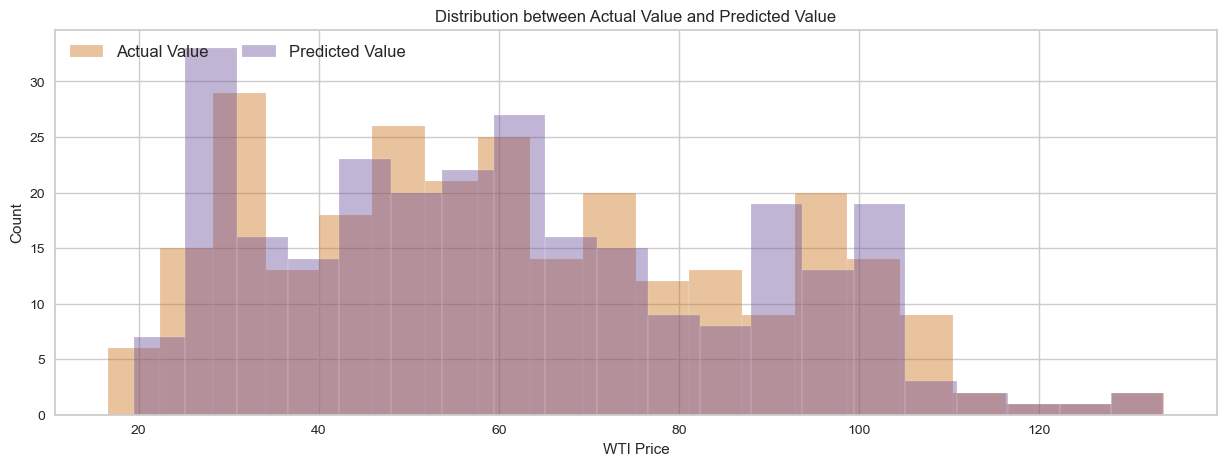

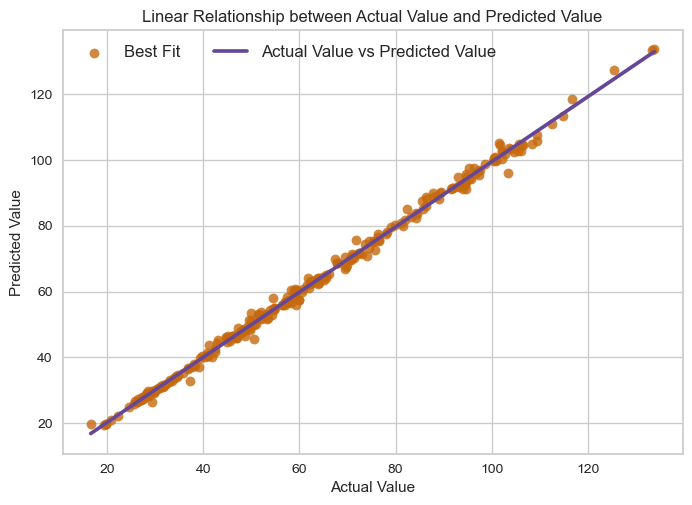

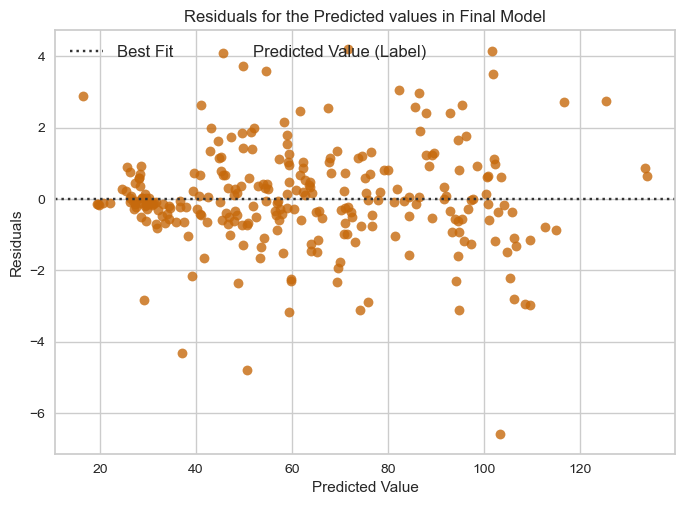


regression_model_2m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2.5744,11.4771,3.3878,0.9778,0.0569,0.0458


,wti_price,prediction_label,redisual
count,269.000000,269.000000,269.000000
mean,62.315987,62.334339,1.497444
std,26.021173,25.445073,1.333351
min,16.549999,19.365836,0.002864
25%,41.122002,43.626954,0.495903
50%,59.083000,58.673329,1.223003
75%,82.303001,83.185084,1.977818
max,133.880005,127.678157,6.937994


RMSE = 2.0033861769002903


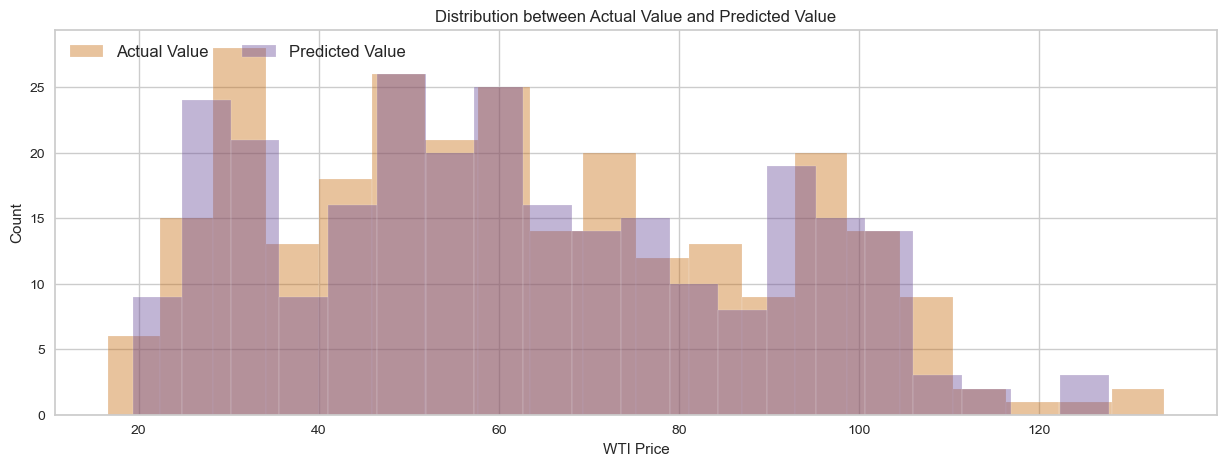

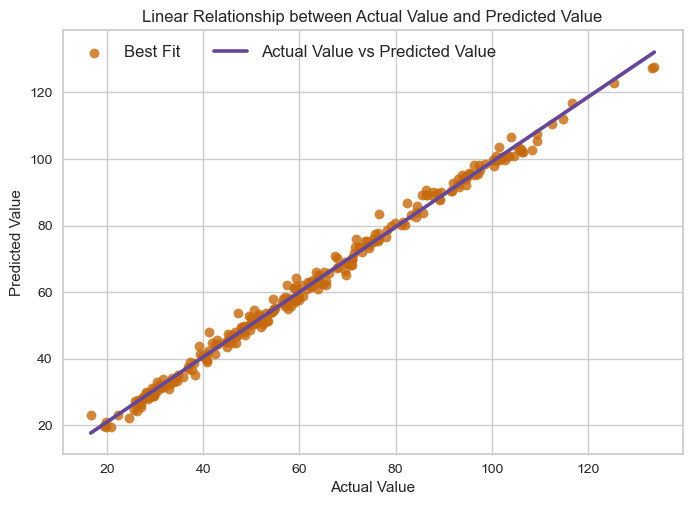

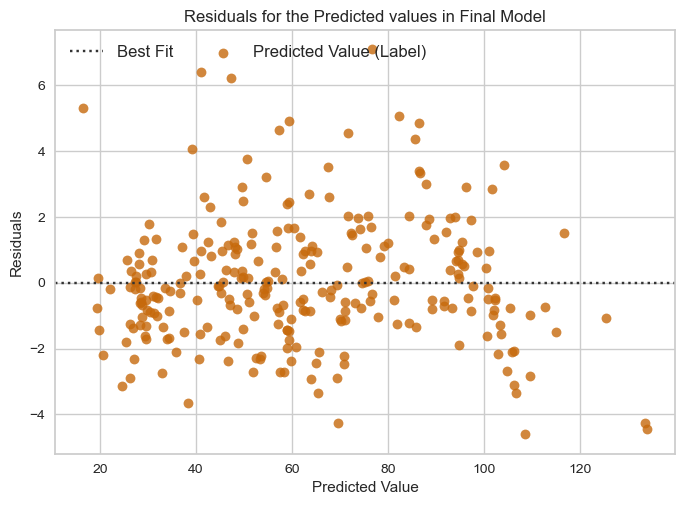


regression_model_3m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.9293,15.0274,3.8765,0.97,0.0682,0.0532


,wti_price,prediction_label,redisual
count,268.000000,268.000000,268.000000
mean,62.437157,62.438127,1.344855
std,25.993702,26.033138,1.538373
min,16.549999,19.738260,0.004310
25%,41.563000,40.854038,0.252350
50%,59.174000,60.594325,0.868740
75%,82.532251,80.497473,1.918828
max,133.880005,133.535635,10.565571


RMSE = 2.041175346993412


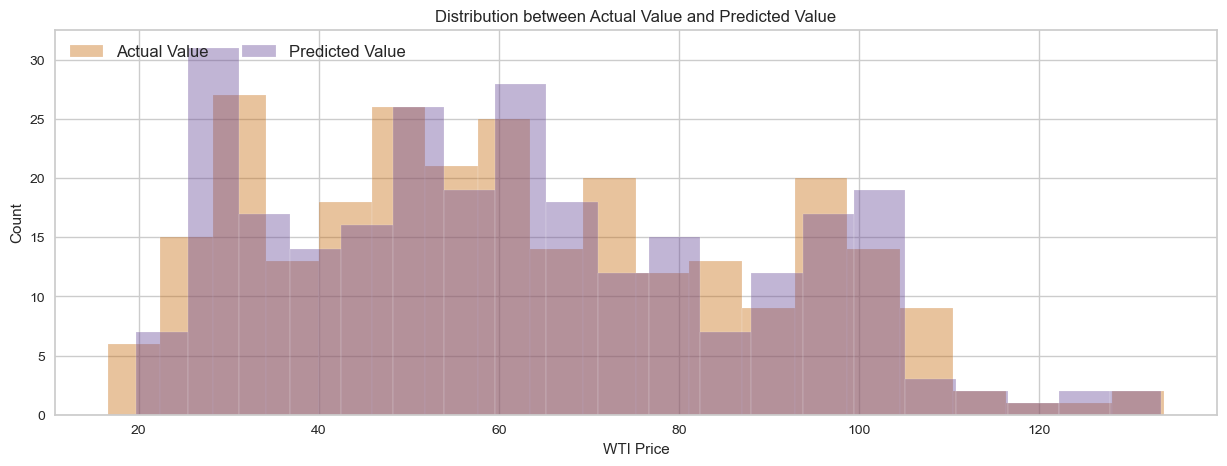

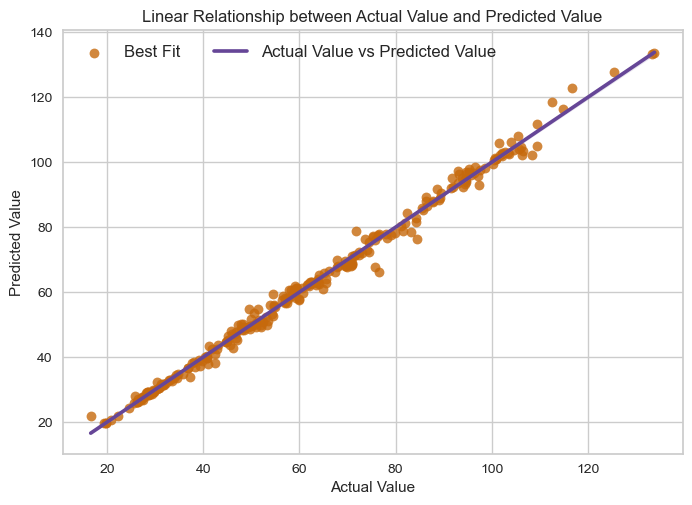

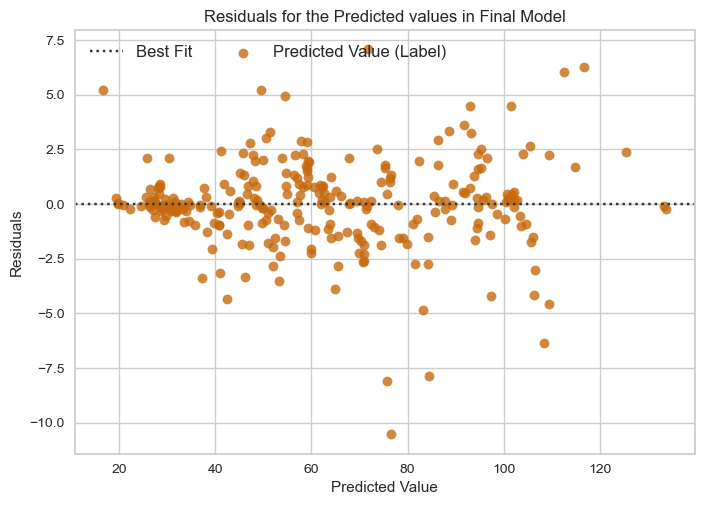


regression_model_4m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,3.1946,19.7815,4.4476,0.9633,0.0897,0.0623


,wti_price,prediction_label,redisual
count,267.000000,267.000000,267.000000
mean,62.574665,62.574425,1.888237
std,25.944679,25.047099,1.670684
min,16.549999,20.058293,0.008947
25%,42.025000,43.561996,0.659868
50%,59.264999,59.696832,1.407048
75%,82.761501,82.337488,2.595937
max,133.880005,129.064635,9.811282


RMSE = 2.5191604138914783


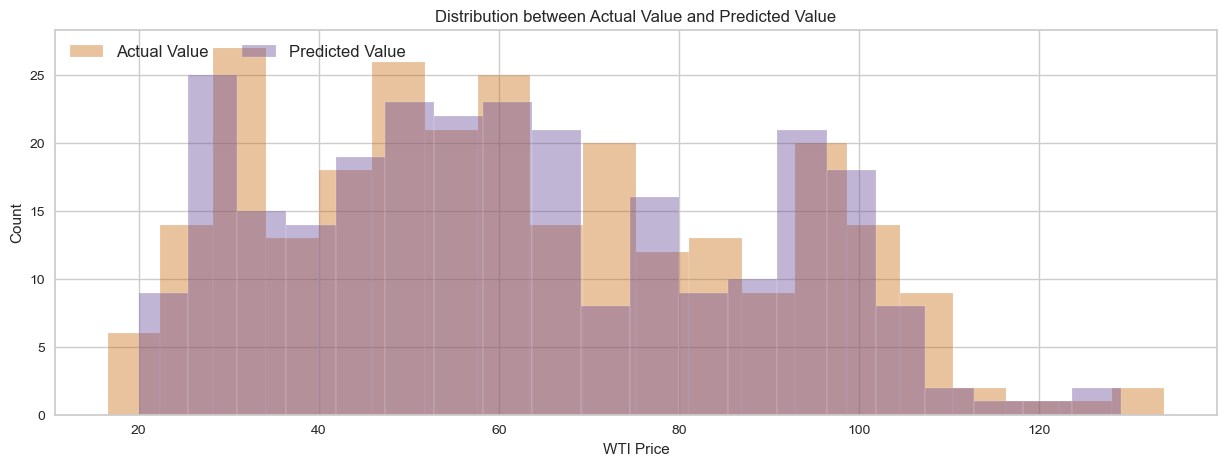

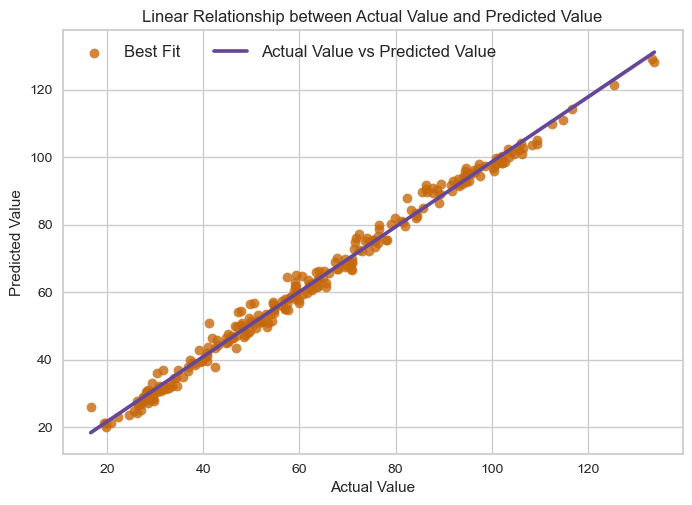

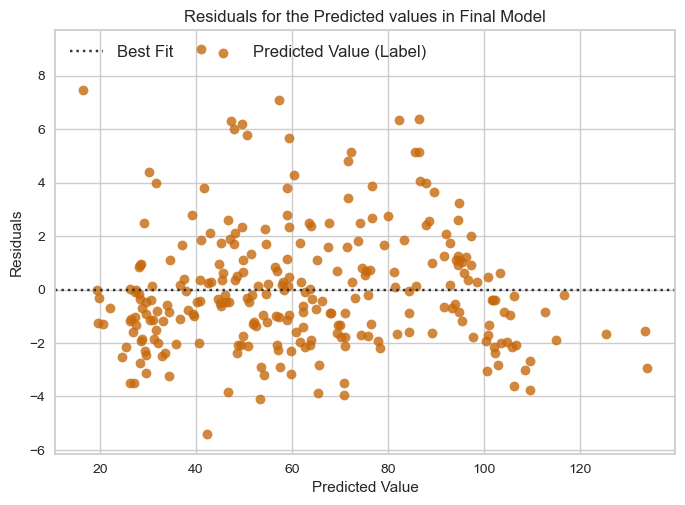


regression_model_5m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,3.0288,18.0729,4.2512,0.9682,0.0755,0.0548


,wti_price,prediction_label,redisual
count,266.000000,266.000000,266.000000
mean,62.701687,62.732323,1.296706
std,25.910280,25.816094,1.833766
min,16.549999,19.493820,0.000450
25%,42.365750,42.861157,0.284192
50%,59.271999,58.532985,0.681265
75%,82.990751,83.128400,1.591598
max,133.880005,133.210465,17.086811


RMSE = 2.2431008249579447


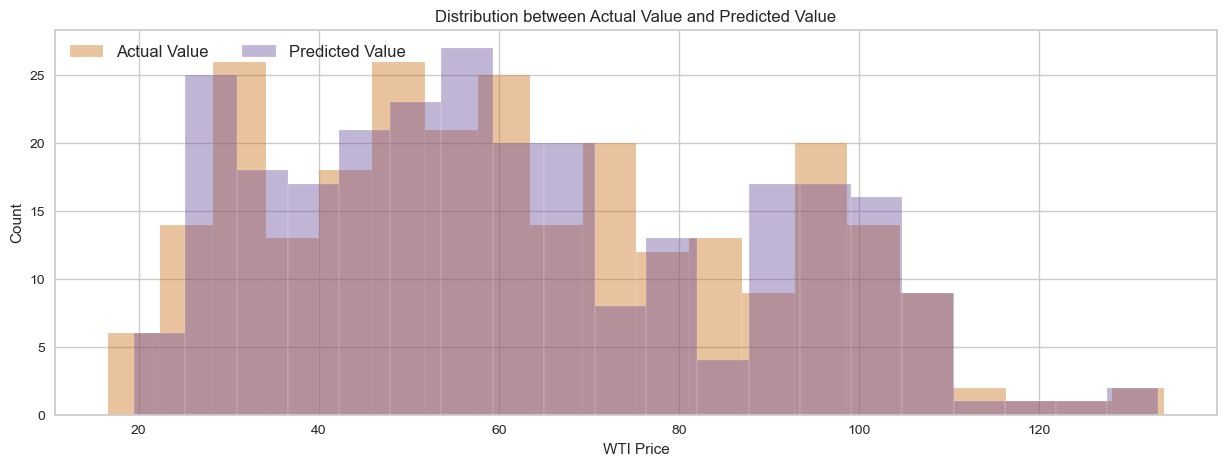

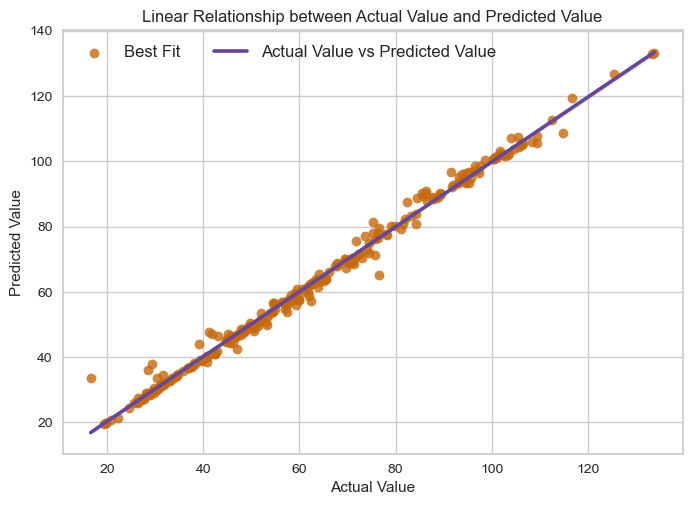

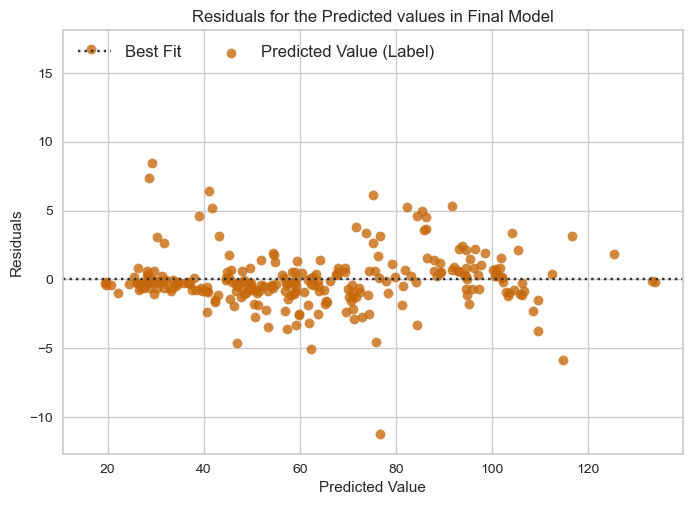


regression_model_6m


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,3.0283,17.3493,4.1652,0.9708,0.0744,0.0544


,wti_price,prediction_label,redisual
count,265.000000,265.000000,265.000000
mean,62.818211,62.945117,1.289334
std,25.889380,25.925316,1.924878
min,16.549999,19.389000,0.000000
25%,42.443001,41.265240,0.229520
50%,59.278999,60.102290,0.748931
75%,83.220001,83.279140,1.509389
max,133.880005,133.360905,19.190641


RMSE = 2.3137752650634615


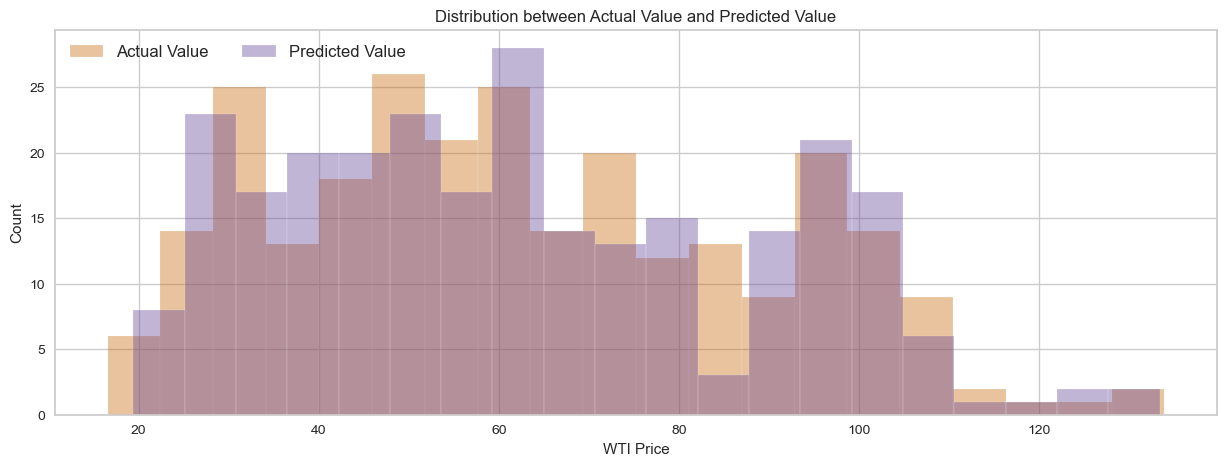

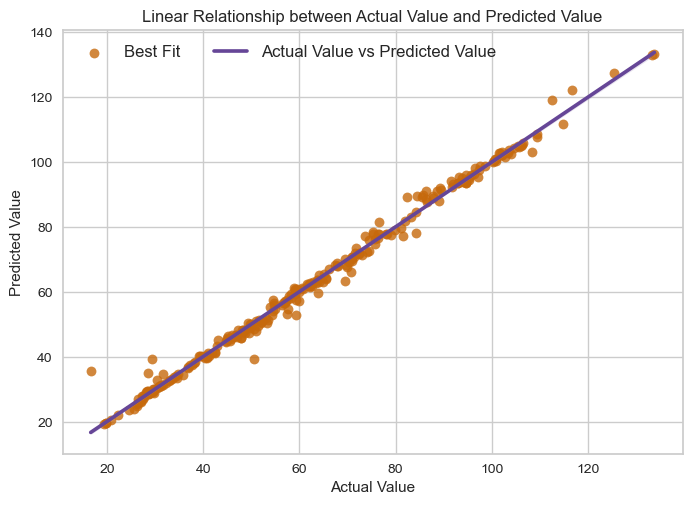

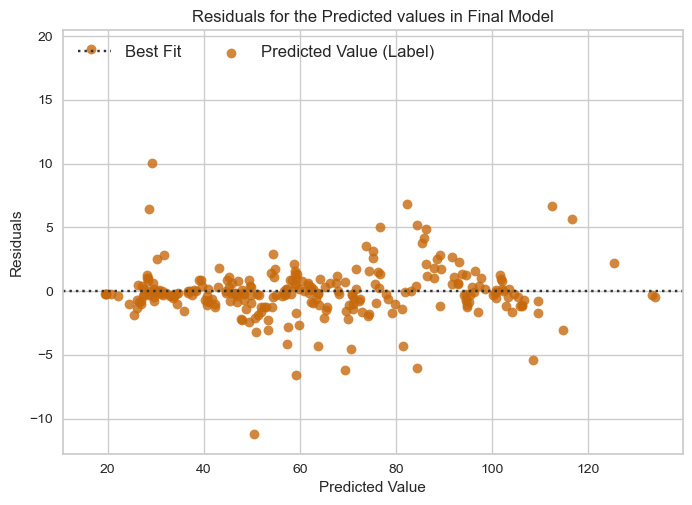

In [18]:
for key, value in models.items():
    
    #gt the model name
    model_name = models[key]['model_file']
    print(model_name)
        
        
    #get the model pipelibe
    pipeline = models[key]['pipeline']
    display(models[key]['metrics'])
    
    
    #Sift the TARGET_FEATURE to dataframe by n-month
    df_shift = shift_column_df(df, TARGET_FEATURE, -1*int(key))
    
    
    #Apply predict_model() on the dataframe 
    prediction = predict_model(pipeline, data=df_shift, verbose = True)
    
    
    #Dscribe prediction
    describe_pred(prediction, TARGET_FEATURE, 'prediction_label')
    print('RMSE =', rmse(prediction, TARGET_FEATURE, 'prediction_label'))
    
    
    #generate pred_scenarion name and store predictions
    pred_scenario = 'pred_' + str(key) + 'm'
    globals()[pred_scenario] = prediction
    
    
    #plot predictions
    plot_distribution(prediction, TARGET_FEATURE)
    plot_actual_vs_predict(prediction, TARGET_FEATURE)
    plot_residuals(prediction, TARGET_FEATURE)
        
    print('')


In [19]:
#Save prediction to excel file
with pd.ExcelWriter(m_path + '\\pred_tables.xlsx', engine='xlsxwriter') as writer:
    # Write each dataframe to one ksheet.
    for key, value in models.items():
        pred_scenario  = 'pred_' + str(key) + 'm'
        globals()[pred_scenario].to_excel(writer, sheet_name=pred_scenario)

## Vizualize Predictions

### Extend Date index for predicted months

In [20]:
#Date range from reading files
dates_read_df = pd.DataFrame(df.index)

In [21]:
#Find the the last date in dates
lst = list(models.items())
last_date = list(dates_read_df['Date'])[-1]
dt_base = str(last_date).split(' ')[0]
print(dt_base)

2022-07-01


In [22]:
#Extend date index for predicted persions
#start date
dt_start = datetime.strptime(dt_base, "%Y-%m-%d").replace(day=1)
dt_start = dt_start + timedelta(days=1)

#end date
numdays = int(lst[-1][0])*31
dt_end = dt_start + timedelta(days=numdays)
dt_end = dt_end.replace(day=1)

In [23]:
#Check the newly added "Dates"
dates_new_df = pd.DataFrame(pd.date_range(start=dt_start, end=dt_end, freq = 'MS'), columns = ['Date'])
dates_new_df

,Date
0,2022-08-01
1,2022-09-01
2,2022-10-01
3,2022-11-01
4,2022-12-01
5,2023-01-01


In [24]:
#Add label if predicted
dates_new_df['prediction'] = True
dates_read_df['prediction'] = False

In [25]:
#append the newly added dates to the dates from data reader
dates_extend = pd.concat([dates_read_df, dates_new_df], axis=0)

In [26]:
#Case the corresponsing date data on extended df (using merge on 'Date)
dates_extend_df = dates_extend.merge(unfiltered_wti, on = 'Date', how = 'left')
dates_extend_df.tail(7)

,Date,prediction,wti_price
270,2022-07-01,False,101.62
271,2022-08-01,True,93.67
272,2022-09-01,True,84.26
273,2022-10-01,True,87.55
274,2022-11-01,True,86.00
275,2022-12-01,True,86.00
276,2023-01-01,True,87.00


### Cast predictions to the dataframe

In [27]:
for key, value in models.items():
    print('month: ', key)
    pipeline = models[key]['pipeline']
    
    # Use predict_model() to calcluate prediction labels
    prediction = predict_model(pipeline, data=df)
    
    #create a column name for each model
    column_name = 'prediction_' + key + 'm'
    df_new = prediction[['prediction_label']]
    df_new = df_new.rename(columns={'prediction_label': column_name}, errors="raise")
    
    #Case the corresponsing date data on extended df (using merge on 'Date)
    dates_extend_df = dates_extend_df.merge(df_new, on = 'Date', how = 'outer')
    
    #since we shifted n-month data by "n" for modeling, here we need to "shift back" the data for visualization
    dates_extend_df[column_name] = dates_extend_df[column_name].shift(int(key))


month:  1
month:  2
month:  3
month:  4
month:  5
month:  6


In [28]:
#Check the exetnded date df with predictions from modelling
display(dates_extend_df.head(7))
display(dates_extend_df.tail(7))

,Date,prediction,wti_price,prediction_1m,prediction_2m,prediction_3m,prediction_4m,prediction_5m,prediction_6m
0,2000-01-01,False,27.259,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-01,False,29.366,29.610619,NaN,NaN,NaN,NaN,NaN
2,2000-03-01,False,29.842,29.674069,29.844863,NaN,NaN,NaN,NaN
3,2000-04-01,False,25.722,26.746620,27.327823,27.90031,NaN,NaN,NaN
4,2000-05-01,False,28.788,28.935700,28.964560,28.75342,29.386307,NaN,NaN
5,2000-06-01,False,31.822,31.095110,31.589949,31.51434,32.204360,31.49237,NaN
6,2000-07-01,False,29.697,29.833570,30.804193,29.71042,30.516507,30.56211,30.04236


,Date,prediction,wti_price,prediction_1m,prediction_2m,prediction_3m,prediction_4m,prediction_5m,prediction_6m
270,2022-07-01,False,101.62,105.204391,103.509619,106.030762,99.705722,102.176581,102.871412
271,2022-08-01,True,93.67,106.194351,103.373617,104.148281,102.160688,90.138151,104.067101
272,2022-09-01,True,84.26,NaN,101.453525,105.408100,100.973839,89.015401,87.561480
273,2022-10-01,True,87.55,NaN,NaN,100.114189,95.530317,78.417071,84.516830
274,2022-11-01,True,86.00,NaN,NaN,NaN,91.741914,77.390991,82.262260
275,2022-12-01,True,86.00,NaN,NaN,NaN,NaN,77.319411,88.294090
276,2023-01-01,True,87.00,NaN,NaN,NaN,NaN,NaN,82.231490


## Plot predictions

### Process the data for plotting

In [29]:
df_plot = dates_extend_df.copy()

#drop 'prediction' column
df_plot.drop(columns='prediction', inplace = True)

#convert 'Date' column to date format
df_plot['Date'] = pd.to_datetime(df_plot['Date'], format='%Y-%m-%d', errors="raise")

#set Date as index
df_plot.set_index('Date', drop=True, inplace=True)

In [30]:
#melt data for creating plot-ready dataframe
df_melt = pd.melt(df_plot, var_name=['model'], value_name='value', col_level=None, ignore_index=False)

In [31]:
#reset index and move "date" from index to a column
df_plot_preds = df_melt.reset_index()
df_plot_preds

,Date,model,value
0,2000-01-01,wti_price,27.25900
1,2000-02-01,wti_price,29.36600
2,2000-03-01,wti_price,29.84200
3,2000-04-01,wti_price,25.72200
4,2000-05-01,wti_price,28.78800
...,...,...,...
1934,2022-09-01,prediction_6m,87.56148
1935,2022-10-01,prediction_6m,84.51683
1936,2022-11-01,prediction_6m,82.26226
1937,2022-12-01,prediction_6m,88.29409


### Plot functions

In [143]:
def relplot_preds(plt_df, ymin, ymax, hue = "model", style = "model", title = 'WTI Price Prediction',):
    
    sns.relplot(x="Date",
        y="value",
        data=plt_df,
        kind="line",
        style=style,
        hue=hue,
        height = 4,
        aspect = 3).set(title=title, ylim=(ymin, ymax))

### Plots

##### All data

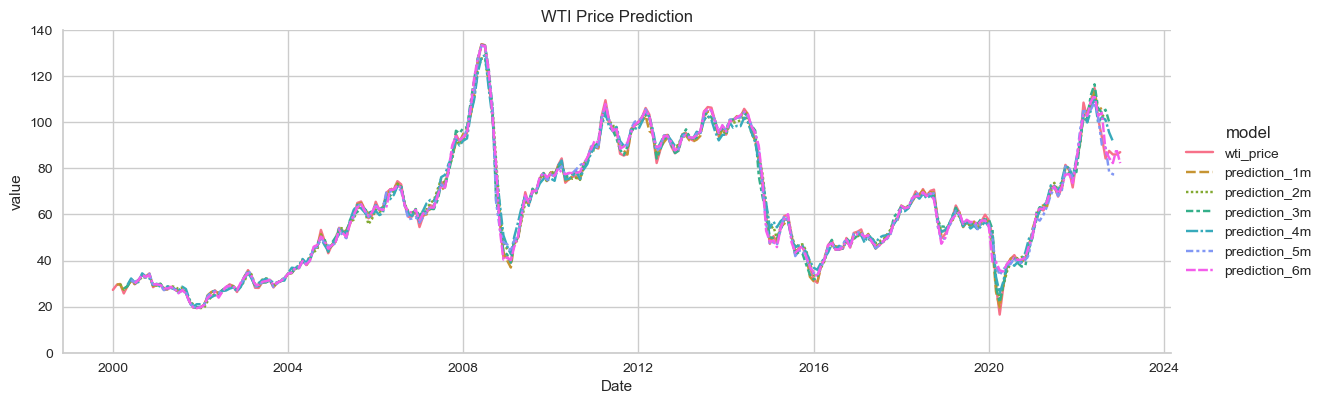

In [144]:
relplot_preds(df_plot_preds, 0, 140)
plt.show()

##### Zoomed in

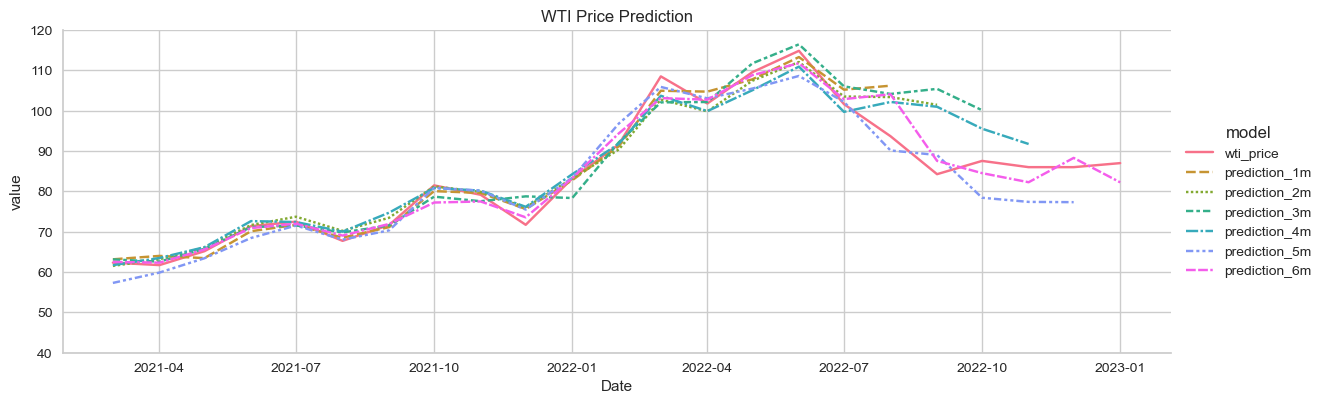

In [145]:
df_plot_zoom = df_plot_preds.loc[df_plot_preds['Date'] >= DATE_ZOOM]
relplot_preds(df_plot_zoom, 40, 120)
plt.show()

## Calculate Expected Average

### Functions

In [35]:
def calculate_weights(size):
    weights = size * [0]
    weights[0] = 1
    for i in range(1,size):
        weights[i] =  weights[i-1]/2.0
    return weights

In [36]:
def power(my_list, p):
    return [ x**p for x in my_list]

### Calclute weighted mean

In [37]:
#Make a copy to store average predictions
df_average = dates_extend_df.copy()
df_average

,Date,prediction,wti_price,prediction_1m,prediction_2m,prediction_3m,prediction_4m,prediction_5m,prediction_6m
0,2000-01-01,False,27.259,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-01,False,29.366,29.610619,NaN,NaN,NaN,NaN,NaN
2,2000-03-01,False,29.842,29.674069,29.844863,NaN,NaN,NaN,NaN
3,2000-04-01,False,25.722,26.746620,27.327823,27.900310,NaN,NaN,NaN
4,2000-05-01,False,28.788,28.935700,28.964560,28.753420,29.386307,NaN,NaN
...,...,...,...,...,...,...,...,...,...
272,2022-09-01,True,84.260,NaN,101.453525,105.408100,100.973839,89.015401,87.56148
273,2022-10-01,True,87.550,NaN,NaN,100.114189,95.530317,78.417071,84.51683
274,2022-11-01,True,86.000,NaN,NaN,NaN,91.741914,77.390991,82.26226
275,2022-12-01,True,86.000,NaN,NaN,NaN,NaN,77.319411,88.29409


### Calculate weights

In [38]:
#Get all RMSE values from models and append to "rmse_all"
rmse_all = []
for key, value in models.items():
    rmse_val = np.float(models[key]['metrics']['RMSE'][0])
    rmse_all.append(rmse_val)
    
rmse_all

[3.2807, 3.3878, 3.8765, 4.4476, 4.2512, 4.1652]

In [39]:
#Calcluate weight as 1/RMSE
weights = power(rmse_all, -1)

In [40]:
#Multiply predictions from models by the "weights"
weights_df = dates_extend_df.notnull().iloc[:,3:]*weights
weights_df = weights_df.div(weights_df.sum(axis=1), axis=0)

In [41]:
#Calclate weighted mean of predictions
df_average['avg_prediction'] = (df_average.iloc[:,3:]*weights_df).sum(axis=1)

### Calcalte average RMSE and upper and lower bounds

In [42]:
#Calcluate average RMSE of multiple models
count_rmse = dates_extend_df.notnull().iloc[:,3:].sum(axis=1)
df_average['avg_rmse'] = np.sqrt(sum(power(rmse_all,2))/count_rmse)

In [43]:
#If the value is not predicted, replace the average prediction with NaN.
df_average['avg_prediction'].loc[df_average['prediction'] == False] = np.nan

2.5758 is used because the 99% confidence interval has only 1% on each side. The probability for a z score below −2.5758 is 1%, and similarly for a z score above +2.5758; added together this is 1%. 

In [44]:
from scipy.stats import norm
alpha = 1-0.01/2
z = norm.ppf(alpha)
print(z)

2.5758293035489004


In [45]:
df_average['upper_bound'] = df_average['avg_prediction'] + df_average['avg_rmse'] * z
df_average['lower_bound'] = df_average['avg_prediction'] - df_average['avg_rmse'] * z

## Visualization and concept

### Prepare data

In [46]:
df_plot_avg = df_average.copy()

#convert 'Date' column to date format
df_plot_avg['Date'] = pd.to_datetime(df_plot_avg['Date'], format='%Y-%m-%d', errors="raise")

#set Date as index
df_plot_avg.set_index('Date', drop=True, inplace=True)

df_plot_avg.tail(8)

,prediction,wti_price,prediction_1m,prediction_2m,prediction_3m,prediction_4m,prediction_5m,prediction_6m,avg_prediction,avg_rmse,upper_bound,lower_bound
Date,,,,,,,,,,,,
2022-06-01,False,114.84,113.287500,112.065254,116.446510,110.918525,108.612809,111.759521,NaN,3.925773,NaN,NaN
2022-07-01,False,101.62,105.204391,103.509619,106.030762,99.705722,102.176581,102.871412,NaN,3.925773,NaN,NaN
2022-08-01,True,93.67,106.194351,103.373617,104.148281,102.160688,90.138151,104.067101,101.987360,3.925773,112.099482,91.875238
2022-09-01,True,84.26,NaN,101.453525,105.408100,100.973839,89.015401,87.561480,97.185757,4.300469,108.263031,86.108483
2022-10-01,True,87.55,NaN,NaN,100.114189,95.530317,78.417071,84.516830,89.803251,4.808071,102.188021,77.418482
2022-11-01,True,86.00,NaN,NaN,NaN,91.741914,77.390991,82.262260,83.669884,5.551882,97.970583,69.369184
2022-12-01,True,86.00,NaN,NaN,NaN,NaN,77.319411,88.294090,82.862821,6.799639,100.377529,65.348112
2023-01-01,True,87.00,NaN,NaN,NaN,NaN,NaN,82.231490,82.231490,9.616141,107.001029,57.461952


In [47]:
#start visualization with upper & lower bounds form `dt_base` date
df_plot_avg['upper_bound'].loc[df_plot_avg.index == dt_base] = df_plot_avg[TARGET_FEATURE]
df_plot_avg['lower_bound'].loc[df_plot_avg.index == dt_base] = df_plot_avg[TARGET_FEATURE]
df_plot_avg['avg_prediction'].loc[df_plot_avg.index == dt_base] = df_plot_avg[TARGET_FEATURE]

### Filter dataframe for visualizaton

In [48]:
def filter_df_by_index(df, start, end):
    filter_idx = (df.index >= start) & (df.index <= end)
    return df.loc[filter_idx]

### Final plot with upper and lower bounds

In [49]:
df_plot_pred_zoom = filter_df_by_index(df_plot_avg, dt_base, dt_end)

In [50]:
#melt data for creating plot-ready dataframe
df_melt_avg = pd.melt(df_plot_pred_zoom,
                      var_name=None,
                      value_vars = ['wti_price', 'avg_prediction', 'upper_bound', 'lower_bound'],
                      value_name='value',
                      col_level=None,
                      ignore_index=False)

#reset index and move "date" from index to a column
df_plot_pred = df_melt_avg.reset_index()

In [51]:
df_plot_pred.head()

,Date,variable,value
0,2022-07-01,wti_price,101.62
1,2022-08-01,wti_price,93.67
2,2022-09-01,wti_price,84.26
3,2022-10-01,wti_price,87.55
4,2022-11-01,wti_price,86.00


In [52]:
#melt data for creating plot-ready dataframe
df_plot_wti_zoom = filter_df_by_index(df_plot_avg, DATE_ZOOM, dt_base)
df_plot_wti = df_plot_wti_zoom[[TARGET_FEATURE]]
df_plot_wti.head()

,wti_price
Date,
2021-03-01,62.33
2021-04-01,61.72
2021-05-01,65.17
2021-06-01,71.38
2021-07-01,72.49


In [53]:
#melt data for creating plot-ready dataframe
df_plot_wti_future = filter_df_by_index(df_plot_avg, dt_base, dt_end)
df_plot_wti_future = df_plot_wti_future[[TARGET_FEATURE]]
df_plot_wti_future.head()

,wti_price
Date,
2022-07-01,101.62
2022-08-01,93.67
2022-09-01,84.26
2022-10-01,87.55
2022-11-01,86.00


In [54]:
df_plot_pred

,Date,variable,value
0,2022-07-01,wti_price,101.620000
1,2022-08-01,wti_price,93.670000
2,2022-09-01,wti_price,84.260000
3,2022-10-01,wti_price,87.550000
4,2022-11-01,wti_price,86.000000
5,2022-12-01,wti_price,86.000000
6,2023-01-01,wti_price,87.000000
7,2022-07-01,avg_prediction,101.620000
8,2022-08-01,avg_prediction,101.987360
9,2022-09-01,avg_prediction,97.185757


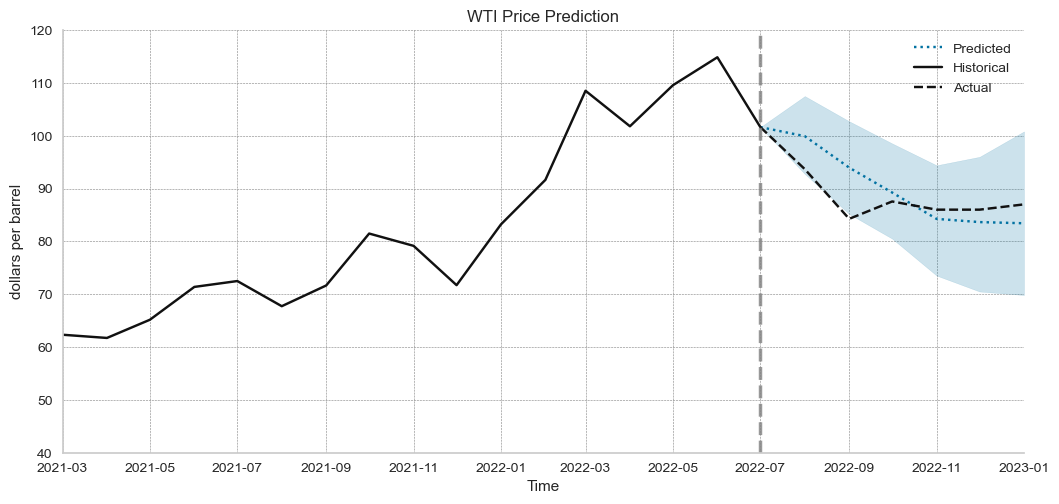

In [55]:
############ PARAMETERS ############
vline = df_plot_wti_future.index[0]
xlim_begin = df_plot_wti.index[0]
xlim_end = df_plot_wti_future.index[-1]

ylim = (40,120)
xlim = (xlim_begin, xlim_end)

############### PLOT ###############
# mean predicted price and C.I. highlights
sns.relplot(x="Date",
    y="value",
    data=df_plot_pred,
    kind="line",
    style=None,
    hue=None,
    label = 'Predicted',
    linestyle = 'dotted',
    aspect = 2.1).set(ylim=ylim, xlim = xlim)

# Historical data
sns.lineplot(x='Date',
    y="wti_price",
    data=df_plot_wti,
    label = 'Historical',
    linestyle = 'solid',
    color = 'k')

# Actual data (future)
sns.lineplot(x='Date',
    y="wti_price",
    data=df_plot_wti_future,
    label = 'Actual',
    linestyle = 'dashed',
    color = 'k').set(title='WTI Price Prediction', ylabel='dollars per barrel', xlabel='Time')

#change chart 
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.4)
plt.axvline(x=vline, c='gray', linewidth = 2.5, ls='--', alpha=0.8)


plt.show()